In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

import cv2
from tqdm import tqdm

from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense,Input,Activation,Subtract,Conv2D,BatchNormalization,Multiply
from tensorflow.keras.layers import MaxPooling2D,UpSampling2D,Concatenate,Add,GlobalAveragePooling2D
from tensorflow.keras.layers import Conv2DTranspose,LeakyReLU,Flatten,Reshape
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.preprocessing.image import img_to_array

In [4]:
inputShape = (224, 224, 1)
inputs = Input(shape=inputShape)
x = inputs

x = Conv2D(32, (3, 3), strides=2, padding="same")(x)
x = LeakyReLU(alpha=0.2)(x)
x = BatchNormalization(axis=-1)(x)

x = Conv2D(64, (3, 3), strides=2, padding="same")(x)
x = LeakyReLU(alpha=0.2)(x)
x = BatchNormalization(axis=-1)(x)

x = Conv2D(128, (3, 3), strides=2, padding="same")(x)
x = LeakyReLU(alpha=0.2)(x)
x = BatchNormalization(axis=-1)(x)

x = Conv2D(256, (3, 3), strides=2, padding="same")(x)
x = LeakyReLU(alpha=0.2)(x)
x = BatchNormalization(axis=-1)(x)

x = Conv2D(512, (3, 3), strides=2, padding="same")(x)
x = LeakyReLU(alpha=0.2)(x)
x = BatchNormalization(axis=-1)(x)

volumeSize = K.int_shape(x)

x = Flatten()(x)
latent = Dense(16)(x)
encoder = Model(inputs, latent, name="encoder")

In [5]:
latentInputs = Input(shape=(16,))
x = Dense(np.prod(volumeSize[1:]))(latentInputs)
x = Reshape((volumeSize[1], volumeSize[2], volumeSize[3]))(x)

x = Conv2DTranspose(512, (3, 3), strides=2,padding="same")(x)
x = LeakyReLU(alpha=0.2)(x)
x = BatchNormalization(axis=-1)(x)

x = Conv2DTranspose(256, (3, 3), strides=2,padding="same")(x)
x = LeakyReLU(alpha=0.2)(x)
x = BatchNormalization(axis=-1)(x)

x = Conv2DTranspose(128, (3, 3), strides=2,padding="same")(x)
x = LeakyReLU(alpha=0.2)(x)
x = BatchNormalization(axis=-1)(x)

x = Conv2DTranspose(64, (3, 3), strides=2,padding="same")(x)
x = LeakyReLU(alpha=0.2)(x)
x = BatchNormalization(axis=-1)(x)

x = Conv2DTranspose(32, (3, 3), strides=2,padding="same")(x)
x = LeakyReLU(alpha=0.2)(x)
x = BatchNormalization(axis=-1)(x)

x = Conv2DTranspose(1, (3, 3), padding="same")(x)
outputs = Activation("sigmoid")(x)

decoder = Model(latentInputs, outputs, name="decoder")

In [6]:
autoencoder = Model(inputs, decoder(encoder(inputs)),name="autoencoder")
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 1)]     0         
_________________________________________________________________
encoder (Functional)         (None, 16)                1973392   
_________________________________________________________________
decoder (Functional)         (None, 224, 224, 1)       4357761   
Total params: 6,331,153
Trainable params: 6,327,185
Non-trainable params: 3,968
_________________________________________________________________


In [7]:
noise_data = []
path1 = "/content/drive/MyDrive/Motion Artifact/Noisy/"
files = os.listdir(path1)
for i in tqdm(files):
    img = cv2.imread(path1 + '/'+i, 0)
    img = cv2.resize(img,(224,224))
    noise_data.append(img_to_array(img))

100%|██████████| 1000/1000 [03:39<00:00,  4.56it/s]


In [8]:
clean_data = []
path2 = "/content/drive/MyDrive/Motion Artifact/Normal_1000"
files = os.listdir(path2)
for i in tqdm(files):
    img = cv2.imread(path2 + '/'+i, 0)
    img = cv2.resize(img,(224,224))
    clean_data.append(img_to_array(img))

100%|██████████| 1000/1000 [04:17<00:00,  3.89it/s]


In [9]:
noisy_train = np.reshape(noise_data,(len(noise_data),224,224,1))
noisy_train = noisy_train.astype('float32')/255.

clean_train = np.reshape(clean_data,(len(clean_data),224,224,1))
clean_train = clean_train.astype('float32')/255.

In [10]:
x_train, x_test, y_train, y_test = train_test_split(noisy_train, clean_train, 
                                                    test_size = 0.20, random_state = 0)

In [11]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(800, 224, 224, 1)
(800, 224, 224, 1)
(200, 224, 224, 1)
(200, 224, 224, 1)


In [12]:
autoencoder.compile(loss="mse", optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3))

In [13]:
history = autoencoder.fit(x_train, y_train,validation_data=(x_test, y_test),
                          epochs=50,batch_size=32)

Epoch 1/50
25/25 [==============================] - 45s 444ms/step - loss: 0.0534 - val_loss: 0.0619
Epoch 2/50
25/25 [==============================] - 10s 410ms/step - loss: 0.0360 - val_loss: 0.0559
Epoch 3/50
25/25 [==============================] - 10s 409ms/step - loss: 0.0351 - val_loss: 0.0505
Epoch 4/50
25/25 [==============================] - 10s 408ms/step - loss: 0.0350 - val_loss: 0.0484
Epoch 5/50
25/25 [==============================] - 10s 408ms/step - loss: 0.0353 - val_loss: 0.0426
Epoch 6/50
25/25 [==============================] - 10s 408ms/step - loss: 0.0349 - val_loss: 0.0414
Epoch 7/50
25/25 [==============================] - 10s 409ms/step - loss: 0.0348 - val_loss: 0.0396
Epoch 8/50
25/25 [==============================] - 10s 407ms/step - loss: 0.0346 - val_loss: 0.0391
Epoch 9/50
25/25 [==============================] - 10s 408ms/step - loss: 0.0344 - val_loss: 0.0407
Epoch 10/50
25/25 [==============================] - 10s 408ms/step - loss: 0.0342 - val_lo

In [14]:
no_noise_img = autoencoder.predict(x_test)

In [15]:
original = (x_test[1] * 255).astype("uint8")
denoised = (no_noise_img[1] * 255).astype("uint8")

In [16]:
original = np.squeeze(original) 
denoised = np.squeeze(denoised) 

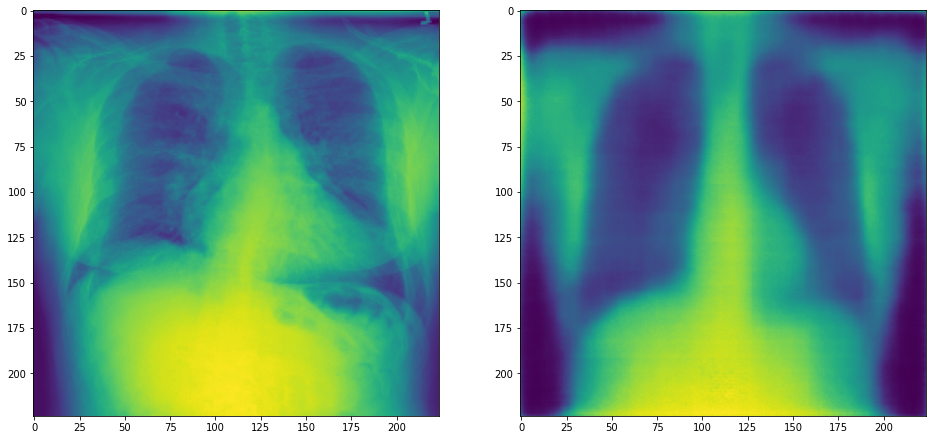

In [17]:
plt.figure(figsize=(16,9))
plt.subplot(121)
plt.imshow(original)
plt.subplot(122)
plt.imshow(denoised)

(<matplotlib.axes._subplots.AxesSubplot at 0x7fa840f5aed0>,
 Text(0.5, 1.0, 'denoised'))

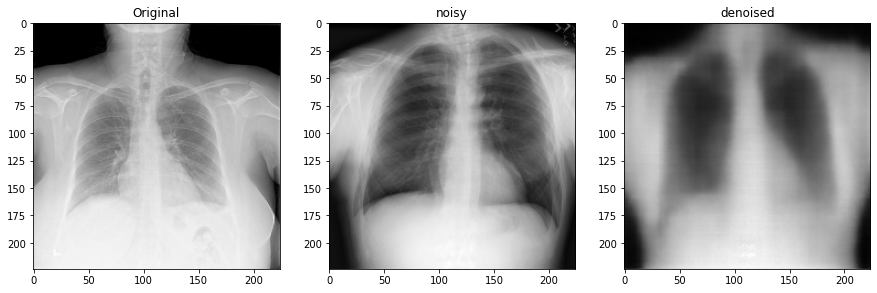

In [19]:
plt.figure(figsize=(15,12))
plt.subplot(131), plt.imshow(np.squeeze(y_test[2]), cmap="gray"),plt.title('Original')
plt.subplot(132), plt.imshow(np.squeeze(x_test[2]),cmap="gray"),plt.title('noisy')
plt.subplot(133), plt.imshow(np.squeeze(no_noise_img[2]),cmap="gray"),plt.title('denoised')

In [20]:
from skimage.metrics import peak_signal_noise_ratio
from skimage import io
from scipy import ndimage as nd

noise_psnr = peak_signal_noise_ratio(y_test[2], x_test[2])
gaussian_cleaned_psnr = peak_signal_noise_ratio(y_test[2], no_noise_img[2])
print("PSNR of input noisy image = ", noise_psnr)
print("PSNR of cleaned image = ", gaussian_cleaned_psnr)

PSNR of input noisy image =  11.028676928897339
PSNR of cleaned image =  12.992056842702562
